In [1]:
!pip install xgboost
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import csv

In [3]:
read = pd.read_csv("train70_reduced.csv", nrows=10000)

In [4]:
dataframe = pd.DataFrame(read)

In [5]:
# divisão em duas classes

for index, row in dataframe.iterrows():
    if row['target'] == 'flood':
        dataframe.at[index, 'target'] = '1'
    else:
        dataframe.at[index, 'target'] = '0'
        
print(dataframe['target'].unique())

['0' '1']


In [6]:
# para a feature TCP Flags

for number, row in dataframe.iterrows():                     # number represents de index of the column
    if row['tcp.flags'] == "0x00000010":                # row represents the data of the row
        dataframe.at[number, 'tcp.flags'] = "ACK"            # the method at. update the row to the new value
    elif row['tcp.flags'] == "0x00000002":
        dataframe.at[number, 'tcp.flags'] = "SYN"
    elif row['tcp.flags'] == "0x00000012":
        dataframe.at[number, 'tcp.flags'] = "SYN ACK"
    elif row['tcp.flags'] == "0x00000011":
        dataframe.at[number, 'tcp.flags'] = "FIN ACK"
    elif row['tcp.flags'] == "0x00000004":
        dataframe.at[number, 'tcp.flags'] = "RST"
    elif row['tcp.flags'] == "0x00000014":
        dataframe.at[number, 'tcp.flags'] = "RST ACK"
    elif row['tcp.flags'] == "0x00000018":
        dataframe.at[number, 'tcp.flags'] = "PSH ACK"
    elif row['tcp.flags'] == "0x00000019":
        dataframe.at[number, 'tcp.flags'] = "ZERO"
        
        
# para a feature MQTT Flags

for number, row in dataframe.iterrows():                             # number represents de index of the column
    if row['mqtt.hdrflags'] == "0x00000030":                    # row represents the data of the row
        dataframe.at[number, 'mqtt.hdrflags'] = "110000"             # the method at. update the row to the new value
    elif row['mqtt.hdrflags'] == "0x00000032":
        dataframe.at[number, 'mqtt.hdrflags'] = "110010"
    elif row['mqtt.hdrflags'] == "0x00000040":
        dataframe.at[number, 'mqtt.hdrflags'] = "1000000"
    elif row['mqtt.hdrflags'] == "0":
        dataframe.at[number, 'mqtt.hdrflags'] = "0"
    elif row['mqtt.hdrflags'] == "0x00000020":
        dataframe.at[number, 'mqtt.hdrflags'] = "100000"
    elif row['mqtt.hdrflags'] == "0x0000003a":
        dataframe.at[number, 'mqtt.hdrflags'] = "111010"
    elif row['mqtt.hdrflags'] == "0x000000d0":
        dataframe.at[number, 'mqtt.hdrflags'] = "11010000"
    elif row['mqtt.hdrflags'] == "0x000000c0":
        dataframe.at[number, 'mqtt.hdrflags'] = "11000000"
    elif row['mqtt.hdrflags'] == "0x00000010":
        dataframe.at[number, 'mqtt.hdrflags'] = "10000"
    elif row['mqtt.hdrflags'] == "0x00000090":
        dataframe.at[number, 'mqtt.hdrflags'] = "10010000"
    elif row['mqtt.hdrflags'] == "0x00000031":
        dataframe.at[number, 'mqtt.hdrflags'] = "110001"
    elif row['mqtt.hdrflags'] == "0x00000050":
        dataframe.at[number, 'mqtt.hdrflags'] = "1010000"
    elif row['mqtt.hdrflags'] == "0x00000082":
        dataframe.at[number, 'mqtt.hdrflags'] = "10000010"
    elif row['mqtt.hdrflags'] == "0x000000e0":
        dataframe.at[number, 'mqtt.hdrflags'] = "11100000"

In [7]:
# remoção das features que, visualmente, não são de forte influência nesse tipo de tráfego


# "to_dataset_dos" é o nome da variável apenas para a leitura dos dados sem as colunas irrelevantes, 
# pois posteriormente será necessária uma nova variável para ajustar as variáveis categóricas e tratar 
# os dados finais.

to_dataset_dos = dataframe.drop(columns = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos', 'mqtt.conflag.reserved', 'mqtt.conflag.retain', 
             'mqtt.conflag.willflag', 'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len', 
             'mqtt.willtopic', 'mqtt.willtopic_len', 'mqtt.msg'])

print(to_dataset_dos.shape)

(10000, 20)


In [8]:
# aplicação da função dummies para ajustar as variáveis categóricas com a definição
# da nova variável 

# ajuste das features sem a última coluna, que são os rótulos

feature_names = pd.get_dummies(to_dataset_dos.iloc[:,:-1])
target = to_dataset_dos['target']

print(feature_names.shape)
print(list(feature_names.keys()))

(10000, 42)
['tcp.time_delta', 'tcp.len', 'mqtt.conack.val', 'mqtt.conflag.cleansess', 'mqtt.conflag.passwd', 'mqtt.conflag.uname', 'mqtt.dupflag', 'mqtt.kalive', 'mqtt.len', 'mqtt.msgid', 'mqtt.msgtype', 'mqtt.proto_len', 'mqtt.qos', 'mqtt.ver', 'tcp.flags_ACK', 'tcp.flags_FIN ACK', 'tcp.flags_PSH ACK', 'tcp.flags_RST', 'tcp.flags_RST ACK', 'tcp.flags_SYN', 'tcp.flags_SYN ACK', 'tcp.flags_ZERO', 'mqtt.conack.flags_0', 'mqtt.conack.flags_0x00000000', 'mqtt.conflags_0', 'mqtt.conflags_0x00000002', 'mqtt.conflags_0x000000c2', 'mqtt.hdrflags_0', 'mqtt.hdrflags_10000', 'mqtt.hdrflags_100000', 'mqtt.hdrflags_1000000', 'mqtt.hdrflags_10000010', 'mqtt.hdrflags_10010000', 'mqtt.hdrflags_1010000', 'mqtt.hdrflags_110000', 'mqtt.hdrflags_11000000', 'mqtt.hdrflags_110001', 'mqtt.hdrflags_110010', 'mqtt.hdrflags_11010000', 'mqtt.hdrflags_111010', 'mqtt.protoname_0', 'mqtt.protoname_MQTT']


In [9]:
# classificação de relevância das features com Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500, n_jobs=1)
rfc.fit(feature_names, target)

RandomForestClassifier(n_estimators=500, n_jobs=1)

In [10]:
for name, score in zip(feature_names, rfc.feature_importances_):
    print(name, score)

tcp.time_delta 0.2883694498303646
tcp.len 0.5043590093267051
mqtt.conack.val 2.3227189624135248e-07
mqtt.conflag.cleansess 0.002103988372936708
mqtt.conflag.passwd 1.9801378129730498e-07
mqtt.conflag.uname 6.185241089485255e-07
mqtt.dupflag 0.0003148099501308167
mqtt.kalive 0.0009380181868029567
mqtt.len 0.12945480619584135
mqtt.msgid 0.008096149946265452
mqtt.msgtype 0.006837555875204175
mqtt.proto_len 0.0010522009747370145
mqtt.qos 0.00852177281966613
mqtt.ver 0.0017106256191463916
tcp.flags_ACK 0.004148267379496828
tcp.flags_FIN ACK 0.00023821945532839664
tcp.flags_PSH ACK 0.001475542234903741
tcp.flags_RST 9.265109085878595e-05
tcp.flags_RST ACK 8.316638834832069e-07
tcp.flags_SYN 0.0013907280741501063
tcp.flags_SYN ACK 0.0016216039721299266
tcp.flags_ZERO 7.527586590163717e-06
mqtt.conack.flags_0 9.84837871466704e-07
mqtt.conack.flags_0x00000000 1.4297330316713176e-06
mqtt.conflags_0 0.000330730447527362
mqtt.conflags_0x00000002 4.780216913492861e-05
mqtt.conflags_0x000000c2 3.894

In [11]:
# normalização de dados

from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_names)

In [12]:
scaler.mean_

array([2.31052784e-01, 1.42348300e+02, 1.90000000e-02, 8.50000000e-03,
       4.50000000e-03, 4.50000000e-03, 5.24000000e-02, 1.18353300e+02,
       3.10529000e+01, 1.13162010e+03, 2.04210000e+00, 3.40000000e-02,
       1.61200000e-01, 3.40000000e-02, 4.05800000e-01, 1.29000000e-02,
       5.51700000e-01, 5.60000000e-03, 1.00000000e-04, 1.09000000e-02,
       1.11000000e-02, 1.90000000e-03, 9.90900000e-01, 9.10000000e-03,
       9.91500000e-01, 4.00000000e-03, 4.50000000e-03, 3.78500000e-01,
       8.50000000e-03, 9.10000000e-03, 1.16900000e-01, 2.00000000e-04,
       4.00000000e-04, 2.00000000e-04, 3.16200000e-01, 3.00000000e-03,
       2.00000000e-04, 1.08800000e-01, 5.60000000e-03, 5.24000000e-02,
       9.91500000e-01, 8.50000000e-03])

In [13]:
scaler.scale_

array([2.30533260e+00, 7.71363077e+02, 3.07634523e-01, 9.18027777e-02,
       6.69309346e-02, 6.69309346e-02, 2.22832314e-01, 2.77789868e+03,
       6.06143506e+01, 2.24850335e+03, 1.86336459e+00, 3.67211111e-01,
       3.67715325e-01, 3.67211111e-01, 4.91046189e-01, 1.12843210e-01,
       4.97319927e-01, 7.46233208e-02, 9.99949999e-03, 1.03832509e-01,
       1.04770177e-01, 4.35475602e-02, 9.49588858e-02, 9.49588858e-02,
       9.18027777e-02, 6.31189354e-02, 6.69309346e-02, 4.85013144e-01,
       9.18027777e-02, 9.49588858e-02, 3.21301089e-01, 1.41407213e-02,
       1.99959996e-02, 1.41407213e-02, 4.64992000e-01, 5.46900357e-02,
       1.41407213e-02, 3.11388118e-01, 7.46233208e-02, 2.22832314e-01,
       9.18027777e-02, 9.18027777e-02])

In [14]:
scaled = scaler.transform(feature_names)

scaled

array([[ 0.33306006, -0.17157718, -0.0617616 , ..., -0.2351544 ,
         0.09258979, -0.09258979],
       [-0.10019629,  1.70821205, -0.0617616 , ..., -0.2351544 ,
         0.09258979, -0.09258979],
       [-0.1002002 ,  1.70821205, -0.0617616 , ..., -0.2351544 ,
         0.09258979, -0.09258979],
       ...,
       [-0.10022492, -0.17935562, -0.0617616 , ..., -0.2351544 ,
         0.09258979, -0.09258979],
       [ 0.33351596, -0.16768796, -0.0617616 , ..., -0.2351544 ,
         0.09258979, -0.09258979],
       [-0.09968487, -0.17935562, 16.19129071, ..., -0.2351544 ,
         0.09258979, -0.09258979]])

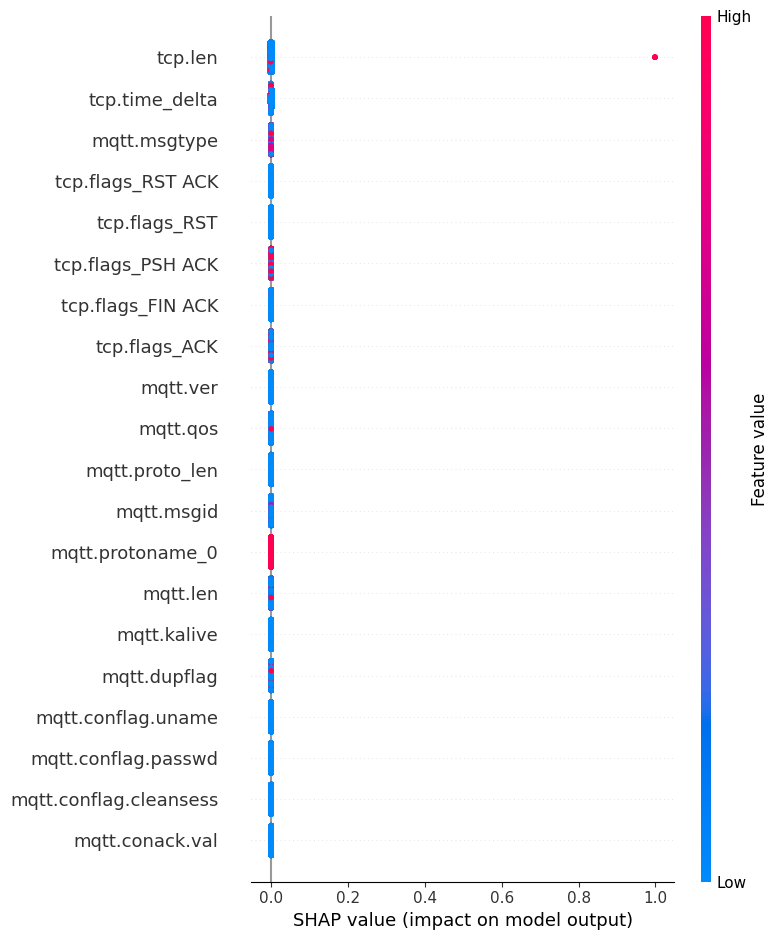

In [17]:
import xgboost
from sklearn.linear_model import LinearRegression
import shap

Xd = xgboost.DMatrix(scaled, label=target)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)


pred = model.predict(Xd, output_margin=True)

# Explicando as predições com SHAP
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(Xd)

shap.summary_plot(explanation, feature_names)

In [19]:
print(feature_names['tcp.flags_ZERO'])

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: tcp.flags_ZERO, Length: 10000, dtype: bool


In [23]:
print(dataframe['target'].value_counts())

target
0    9981
1      19
Name: count, dtype: int64
